<a href="https://colab.research.google.com/github/VickkiMars/CV_Mastery/blob/main/Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: victorthamartian
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer


100%|██████████| 65.2M/65.2M [00:00<00:00, 119MB/s]


In [3]:
import tensorflow as tf
import numpy as np
from keras import layers
import keras
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
filepath = "/content/emotion-detection-fer/"
train_dir = os.path.join(filepath, "train")
test_dir = os.path.join(filepath, "test")

In [5]:
"""
##################################
GET NUMBER OF IMAGES
##################################
"""
for i in os.listdir(train_dir):
  print(f"{i}: {len(os.listdir(os.path.join(train_dir, i)))}")


#GET NUMBER OF CLASSES
print(f"Number of classes: {len(os.listdir(train_dir))}")

happy: 7215
fearful: 4097
neutral: 4965
surprised: 3171
angry: 3995
disgusted: 436
sad: 4830
Number of classes: 7


In [6]:
def show_data_distribution(filepath):
  details = {}
  total_images = 0
  for i in os.listdir(filepath):
    details[i] = len(os.listdir(os.path.join(filepath, i)))
  total_images = sum(details.values())
  for i in details:
    details[i] = round((details[i]/total_images)*100, 2)
  return details

In [7]:
print(show_data_distribution(train_dir))
print(show_data_distribution(test_dir))

{'happy': 25.13, 'fearful': 14.27, 'neutral': 17.29, 'surprised': 11.05, 'angry': 13.92, 'disgusted': 1.52, 'sad': 16.82}
{'happy': 24.71, 'fearful': 14.27, 'neutral': 17.18, 'surprised': 11.58, 'angry': 13.35, 'disgusted': 1.55, 'sad': 17.37}


### **Observation**: The dataset is fairly balanced, therefore, we can proceed with using the dataset

In [8]:
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [9]:
"""
#####################################
LOAD IMAGE AUGMENTATION PARAMETERS
#####################################
"""
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight((0.1, 0.2)),
    tf.keras.layers.RandomWidth((0.1, 0.2)),
    tf.keras.layers.RandomZoom(0.1)
])

In [10]:
def preprocess(image, label):
  image = data_augmentation(image)
  return image, label

In [11]:
IMG_HEIGHT = IMG_WIDTH = 48
BATCH_SIZE = 32
image_size = (IMG_HEIGHT, IMG_WIDTH)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    validation_split=0.2,
    seed=1332,
    subset='training'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    validation_split=0.2,
    seed=1332,
    subset='validation'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 28709 files belonging to 7 classes.


In [12]:
train_ds = train_dataset.map(preprocess)

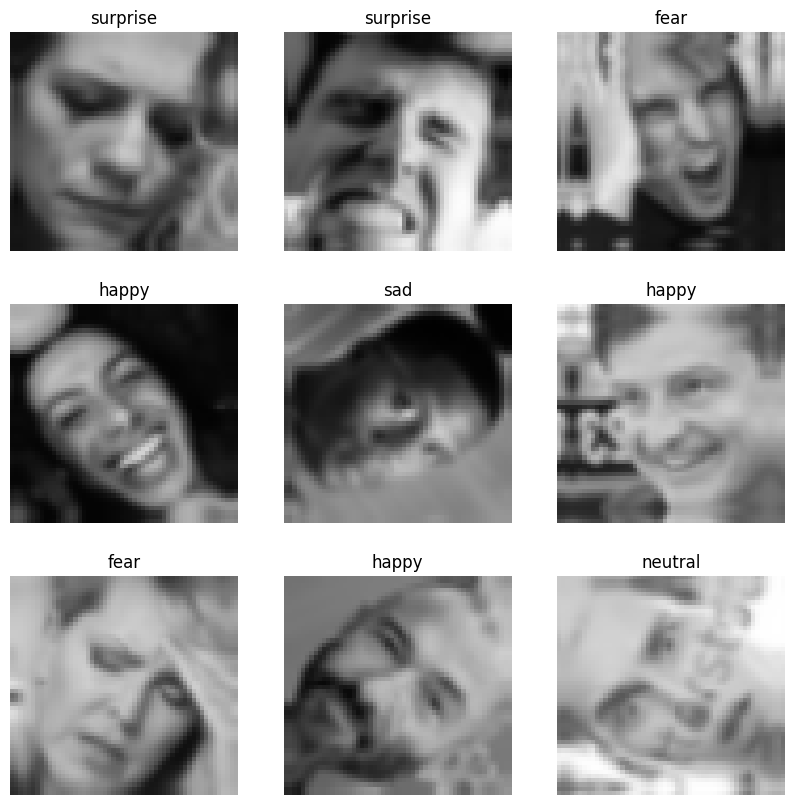

In [13]:
# Visualize the first 9 images in the data
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(labels[np.argmax((label[i]))])
        plt.axis("off")

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

#<> Keras. (2024, October, 23). keras-io [Source Code]. Retrieved from https://github.com/keras-team/keras-io/blob/master/examples/vision/image_classification_from_scratch.py


In [17]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable GPU usage with TensorFlow
# This forces TensorFlow to use the first available GPU (index 0)
with tf.device('/GPU:0'):
    model = make_model(input_shape=image_size + (3,), num_classes=7)
    keras.utils.plot_model(model, show_shapes=True)

    """
    ## Train the model
    """

    epochs = 70

    callbacks = [
        keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
    )
    model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_dataset,
    )

Num GPUs Available:  1
Epoch 1/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 262s 346ms/step - acc: 0.2505 - loss: 1.8268 - val_acc: 0.2510 - val_loss: 1.8513
Epoch 2/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - acc: 0.3281 - loss: 1.6877 - val_acc: 0.2493 - val_loss: 1.9188
Epoch 3/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - acc: 0.3964 - loss: 1.5538 - val_acc: 0.2780 - val_loss: 1.8353
Epoch 4/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - acc: 0.4362 - loss: 1.4530 - val_acc: 0.4015 - val_loss: 1.6198
Epoch 5/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - acc: 0.4680 - loss: 1.3782 - val_acc: 0.4344 - val_loss: 1.4836
Epoch 6/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - acc: 0.4889 - loss: 1.3243 - val_acc: 0.3919 - val_loss: 1.5889
Epoch 7/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - acc: 0.5043 - loss: 1.2946 - val_acc: 0.4259 - val_loss: 1.5353
Epoch 8/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - acc: 0.5151 - loss: 1.2669 - val_acc: 0.4463 - val_loss: 1.4745
Epoch 9/70
718/

In [16]:
model = make_model(input_shape=image_size + (3,), num_classes=7)
keras.utils.plot_model(model, show_shapes=True)

"""
## Train the model
"""

epochs = 70

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataset,
)


Epoch 1/70
 11/718 ━━━━━━━━━━━━━━━━━━━━ 1:19:07 7s/step - acc: 0.8337 - loss: 0.5814

KeyboardInterrupt: 